In [20]:
# Importing Necesasary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import joblib

In [3]:
# Reading the Dataset
df = pd.read_csv("G:\My Drive\ITS\Tugas\Semester_5\Biomedical Engineering\Final Project Req\Dataset.csv")

In [4]:
# Handling Missing Values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Label Targeting and Feature Selection
label = df.columns[-1]
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c != label]

# Preparing Feature Matrix and Target Vector
X = df[feature_cols].values
y_raw = df[label].values

# Label Encoding the Target Variable
le = LabelEncoder()
y = le.fit_transform(df[label])

In [7]:
# Splitting the Dataset into Training and Val-Test Sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Further Splitting Val-Test Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=0.5,
                                                stratify=y_val_test,
                                                random_state=42)

In [ ]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
print("Training set shape:")
print("Shape of X_Train:", X_train.shape)
print("Shape of y_Train:", y_train.shape)

print("\nValidation set shape:")
print("Shape of X_Val:", X_val.shape)
print("Shape of y_Val:", y_val.shape)

print("\nTest set shape:")
print("Shape of X_Test:", X_test.shape)
print("Shape of y_Test:", y_test.shape)


Training set shape:
Shape of X_Train: (669, 20530)
Shape of y_Train: (669,)

Validation set shape:
Shape of X_Val: (143, 20530)
Shape of y_Val: (143,)

Test set shape:
Shape of X_Test: (144, 20530)
Shape of y_Test: (144,)


In [10]:
from tqdm import tqdm
import time

# Enable verbose output for LogisticRegression
lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,
    max_iter=5000,
    n_jobs=-1,
    verbose=1
)

# Wrap the fit method with tqdm for progress bar
print("Training Lasso Logistic Regression...")
start_time = time.time()
lasso.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time / 60:.2f} minutes.")

lasso_coef = np.mean(np.abs(lasso.coef_), axis=0)
lasso_rank_idx = np.argsort(lasso_coef)[::-1]
lasso_genes = []
for i in tqdm(lasso_rank_idx, desc="Ranking features"):
    lasso_genes.append(feature_cols[i])


Training Lasso Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
D:\File\Conda\envs\data-science\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 1828 seconds
Training completed in 1827.82 seconds


Ranking features: 100%|██████████| 20530/20530 [00:00<00:00, 2361805.35it/s]


In [13]:
# Save the model to the specified path
joblib.dump(lasso, 'Saved Model/lasso_logistic_model.pkl')

['Saved Model/lasso_logistic_model.pkl']

In [16]:
y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Training Accuracy: 1.0
Validation Accuracy: 0.8881118881118881

Classification Report (Validation):
              precision    recall  f1-score   support

       Basal       1.00      0.95      0.98        21
        Her2       1.00      0.70      0.82        10
        LumA       0.87      0.92      0.90        65
        LumB       0.79      0.76      0.77        29
      Normal       0.95      1.00      0.97        18

    accuracy                           0.89       143
   macro avg       0.92      0.87      0.89       143
weighted avg       0.89      0.89      0.89       143



In [19]:
# Get feature coefficients and their importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'abs_coefficient': np.abs(lasso.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
       feature  coefficient  abs_coefficient
9538     FABP7     0.049893         0.049893
16648   ABCC11    -0.046319         0.046319
8801   HORMAD1     0.045857         0.045857
17107  CEACAM5    -0.045192         0.045192
18032  CXorf61     0.043413         0.043413
10784     MSLN     0.038449         0.038449
12823    ROPN1     0.034920         0.034920
195       ART3     0.030813         0.030813
18492    VGLL1     0.030169         0.030169
8074       CA9     0.029272         0.029272


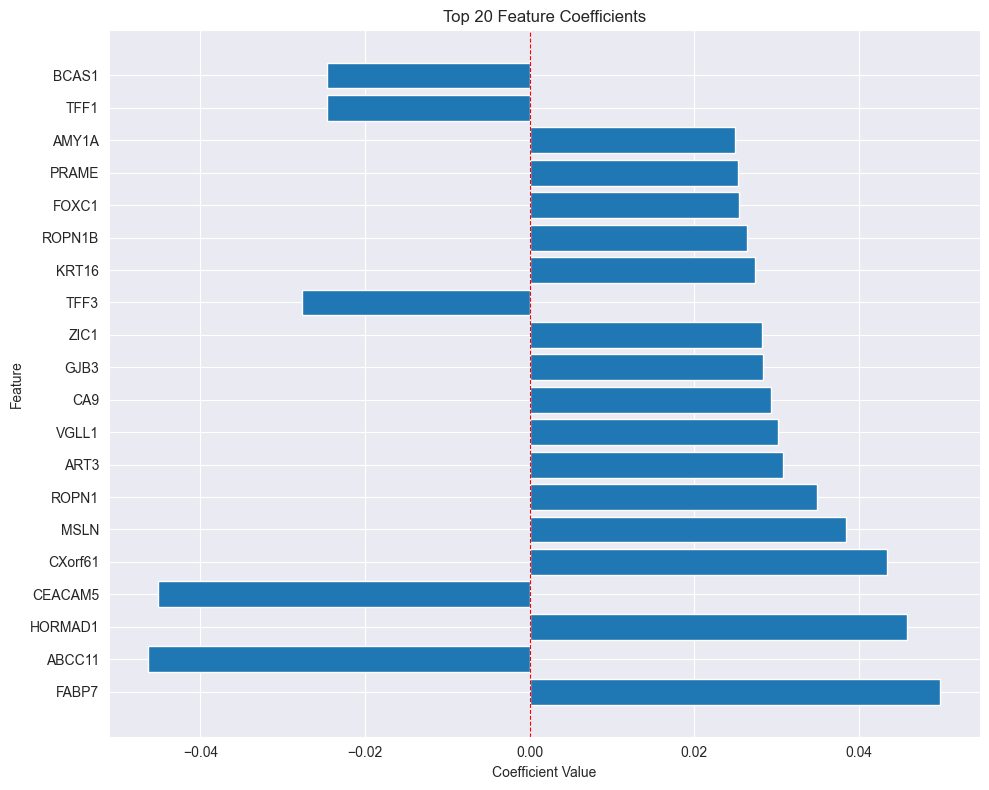

In [21]:
# Plot top 20 feature coefficients
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Coefficients')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [22]:
# Calculate odds ratios for better interpretation
odds_ratios = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'odds_ratio': np.exp(lasso.coef_[0])
}).sort_values('odds_ratio', ascending=False)

print("\nOdds Ratios (exp(coefficient)):")
print(odds_ratios.head(10))
print("\nInterpretation: OR > 1 increases probability, OR < 1 decreases probability")


Odds Ratios (exp(coefficient)):
       feature  coefficient  odds_ratio
9538     FABP7     0.049893    1.051158
8801   HORMAD1     0.045857    1.046925
18032  CXorf61     0.043413    1.044369
10784     MSLN     0.038449    1.039198
12823    ROPN1     0.034920    1.035537
195       ART3     0.030813    1.031293
18492    VGLL1     0.030169    1.030629
8074       CA9     0.029272    1.029705
11871     GJB3     0.028320    1.028725
5629      ZIC1     0.028192    1.028593

Interpretation: OR > 1 increases probability, OR < 1 decreases probability


In [23]:
# Show how the model makes decisions
def explain_prediction(sample_idx):
    sample = X_val[sample_idx].reshape(1, -1)
    prediction = lasso.predict(sample)[0]
    proba = lasso.predict_proba(sample)[0]

    # Calculate contribution of each feature
    contributions = sample[0] * lasso.coef_[0]
    contrib_df = pd.DataFrame({
        'feature': feature_cols,
        'value': sample[0],
        'coefficient': lasso.coef_[0],
        'contribution': contributions
    }).sort_values('contribution', key=abs, ascending=False)

    print(f"Prediction: {le.inverse_transform([prediction])[0]}")
    print(f"Probability: {proba}")
    print("\nTop 10 Contributing Features:")
    print(contrib_df.head(10))

explain_prediction(0)  # Explain first validation sample

Prediction: Normal
Probability: [0.0845466  0.04040477 0.37027679 0.01917081 0.48560104]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
9538     FABP7   7.1168     0.049893      0.355078
16648   ABCC11   7.3286    -0.046319     -0.339455
17107  CEACAM5   6.5504    -0.045192     -0.296026
19117    PRAME  11.1812     0.025318      0.283087
16590     TFF3   9.4802    -0.027702     -0.262620
13725  SCGB2A2  12.6028    -0.017919     -0.225830
1212    C4orf7   9.2477     0.023922      0.221221
4713     FOXC1   8.2412     0.025484      0.210020
9867     BCAS1   8.1146    -0.024614     -0.199729
18492    VGLL1   6.2445     0.030169      0.188392
